# CHURN LABEL

Use this juppyter notebook to spearate the data into Model Development data (The data subset that you will use to train the model) and Model target ( the subset of data that you will apply the model to make predictions)

We will use the model dev data to engineer a churn label based on the Bookings value. We do not create a churn label on the target set as we apply the model on the target dataset

In [1]:
import os
import pandas as pd
import numpy as np
import pickle
import sys
from pandas import HDFStore,DataFrame
from datetime import date, datetime
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

import matplotlib.pyplot as plt
#from matplotlib_venn import venn2
import yaml

cfg = None
    #' load config.yaml file in the root dir 
with open("../config.yaml", 'r') as ymlfile:
    cfg = yaml.load(ymlfile, Loader=yaml.FullLoader)
    
# Use 3 decimal places in output display
pd.set_option("display.precision", 3)

# Don't wrap repr(DataFrame) across additional lines
pd.set_option("display.expand_frame_repr", False)

# Set max rows displayed in output to 25
pd.set_option("display.max_rows", 25)

pd.set_option('display.float_format', lambda x: '%.2f' % x)

pd.options.display.float_format = '${:,.0f}'.format

product_level = 'Product Level 2'

colors = ['#1F77B4', '#FF7F0E']

NA_VALUES_LIST = ['Unknown','nan', 'N.A', 'N.A.', 'NaN', 'Nan', '00-00-00', '0-00-00']

path_to_hdf_datastore = '../'+cfg['path_to_hdf_datastore']


### We define some common function that we will use in our data analysis and engineering.

In [2]:
## Define Required functions

def get_rfm_features_from_contracts(dataframe, group_cols, label=None):    

    dataframe = dataframe.groupby(
        group_cols
    ).agg(revenue=("Bookings - Final Net Price - Agent Discount Amount(Rep)", sum),
        num_contracts=('Agreement Number', pd.Series.nunique),
        num_parents = ('Parent Agreement Number', pd.Series.nunique),
        last_agreement = ('Agreement Start Date', max),
        first_agreement = ('Agreement Start Date', min),
        num_cancellations = ('CHURNED', count)
    ).sort_values('revenue', ascending=False)

    dataframe['last_agreement'] = pd.to_datetime(dataframe['last_agreement'], format='%Y-%m-%d')
    dataframe['first_agreement'] = pd.to_datetime(dataframe['first_agreement'], format='%Y-%m-%d')
    
    dataframe['days_since_last_agreement'] = dataframe['last_agreement'].apply(
        lambda x: (datetime.today() - x).days
        )
    dataframe['days_since_first_agreement'] = dataframe['first_agreement'].apply(
        lambda x: (datetime.today() - x).days
        )
    dataframe['length_of_relationship'] = dataframe['days_since_first_agreement'] - dataframe['days_since_last_agreement'] 
    dataframe = dataframe.drop(['last_agreement', 'first_agreement'], axis=1)
    
    if label is not None:
        dataframe['label'] = label
    
    return dataframe



def append_df_to_excel(filename, df, sheet_name='Sheet1', startrow=None,
                       truncate_sheet=False, 
                       **to_excel_kwargs):
    """
    Append a DataFrame [df] to existing Excel file [filename]
    
    """
    from openpyxl import load_workbook

    import pandas as pd

    # ignore [engine] parameter if it was passed
    if 'engine' in to_excel_kwargs:
        to_excel_kwargs.pop('engine')

    writer = pd.ExcelWriter(filename, engine='openpyxl')

    # Python 2.x: define [FileNotFoundError] exception if it doesn't exist 
    try:
        FileNotFoundError
    except NameError:
        FileNotFoundError = IOError


    try:
        # try to open an existing workbook
        writer.book = load_workbook(filename)

        # get the last row in the existing Excel sheet
        # if it was not specified explicitly
        if startrow is None and sheet_name in writer.book.sheetnames:
            startrow = writer.book[sheet_name].max_row

        # truncate sheet
        if truncate_sheet and sheet_name in writer.book.sheetnames:
            # index of [sheet_name] sheet
            idx = writer.book.sheetnames.index(sheet_name)
            # remove [sheet_name]
            writer.book.remove(writer.book.worksheets[idx])
            # create an empty sheet [sheet_name] using old index
            writer.book.create_sheet(sheet_name, idx)

        # copy existing sheets
        writer.sheets = {ws.title:ws for ws in writer.book.worksheets}
    except FileNotFoundError:
        # file does not exist yet, we will create it
        pass

    if startrow is None:
        startrow = 0

    # write out the new sheet
    df.to_excel(writer, sheet_name, startrow=startrow, **to_excel_kwargs)

    # save the workbook
    writer.save()


    
# Function to drop outliers of numeric columns
def drop_outliers(data_frame, exclude=[], include=[]):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    num_cols = data_frame.select_dtypes(include=numerics).columns

    if len(include) > 0:
        num_cols = np.intersect1d(num_cols, include)
    elif len (exclude) > 0:
        num_cols = num_cols.difference(exclude)
    
    data_frame['DROP'] = False
    for colname in num_cols:
        upper_lim = data_frame[colname].quantile(.95)
        lower_lim = data_frame[colname].quantile(.05)
        
        print(f'Dropping outliers for {colname} upper limit = {upper_lim} and lower limit = {lower_lim}')
        #data_frame = data_frame[(data_frame[colname] < upper_lim) & (data_frame[colname] > lower_lim)]
        data_frame['DROP'] = data_frame['DROP'] | (data_frame[colname] > upper_lim) | (data_frame[colname] < lower_lim)
        
    
    data_frame = data_frame.loc[~data_frame['DROP']]
    print(f'Rows Remaining {data_frame.shape[0]}')
    data_frame = data_frame.drop(['DROP'], axis=1)    
    return data_frame
    
    
def pct_change(df, period1, period2):
    if df[period2] == 0:
        return 0
    elif df[period1] == 0:
        return df[period2]
    else:
        return (df[period2] - df[period1])*100 / df[period1]
    
    
def print_counts(df, cust_id="SIS Id  (Agreement SIS)", prod_id="Product Line Level 2", group_by="TYPE"):
    print(f'Unique Customers : {len(df[cust_id].unique())}')
    print(f'Unique Products at Level 2 : {len(df[prod_id].unique())}')
    print(f'Unique Customer Product Combinations : {len(df[[cust_id, prod_id]].drop_duplicates())}')
    
    if group_by in df.columns:
        print(df.groupby([group_by]).agg(
        customers = (cust_id ,pd.Series.nunique), 
        products = (prod_id,pd.Series.nunique)))

In [3]:
# Read the list of churn products
churn_products = pd.read_hdf(path_to_hdf_datastore, cfg['churn_products_hdf_file'])

In [4]:
# Read contracts data
journals_contracts = pd.read_hdf(path_to_hdf_datastore, cfg['journal_contracts_file'])
other_contracts = pd.read_hdf(path_to_hdf_datastore, cfg['other_contracts_file'])

#set a column variable TYPE to identify journals and solutions contracts
journals_contracts['TYPE'] = 'JOURNALS'
other_contracts['TYPE'] = 'SOLUTIONS'


In [5]:
print('JOURNALS')
print_counts(journals_contracts)
print('SOLUTIONS')
print_counts(other_contracts)

JOURNALS
Unique Customers : 84056
Unique Products at Level 2 : 26
Unique Customer Product Combinations : 139097
          customers  products
TYPE                         
JOURNALS      84056        26
SOLUTIONS
Unique Customers : 34091
Unique Products at Level 2 : 118
Unique Customer Product Combinations : 78088
           customers  products
TYPE                          
SOLUTIONS      34091       118


### Freq table of the Products at Product Line Level 2 in journals contracts

In [6]:
pd.set_option("display.max_rows", 33)
journals_contracts['Product Line Level 2'].value_counts()

Journals Electronic Subscriptions    2439972
Journals Print                       1022415
Journal Level Sales                   284914
Bulk Sales                            157156
Journals Print - One Off               75915
Journals Print Electronic              62341
Hybrid Open Access                     33076
Full Open Access                       17405
Author Page Charges - Print            10871
Journals Backfiles                     10436
Other Revenue Print One Off             8332
Journals Transactions                   7480
Other Income Electronic                 5862
Author Offprint Charges - Print         5182
Editorial Service                       1170
Procedia                                 618
Other Income Print                       518
Conferences - Sponsor                    133
Author Colour Charges - Print            105
Contract Publishing Services              96
Journals Legacy                           77
Journals Subscriptions Electronic         26
Journals O

### Freq table of the Products at Product Line Level 2 in journals contracts

In [7]:
other_contracts['Product Line Level 2'].value_counts()

Nursing & Health Professionals P_ELP    3108106
Research Reference P_ELP                2346220
Medical Reference P_ELP                  970444
Research Reference E_ELP                 836759
Nursing & Health Professionals E_ELP     726362
                                         ...   
ScienceMetrix                                 6
CK China                                      6
Medical Elearning                             5
S&T Books                                     2
Journals Pharma Print Other                   1
Name: Product Line Level 2, Length: 118, dtype: int64

In [8]:
contracts = pd.concat([journals_contracts, other_contracts])
#del journals_contracts, other_contracts

<b>Replace NA values with numpy NaN</b>

In [9]:
contracts.replace(['Unknown','nan', 'N.A', 'N.A.', 'NaN', 'Nan', '00-00-00', '0-00-00'], np.nan, inplace=True)

<b>Convert Text dates to date datatype</b>

In [10]:
date_columns = ['Agreement Start Date', 'Agreement End Date','Subscription Start Date', 'Subscription End Date']

for column in date_columns:
    contracts[column] = pd.to_datetime(contracts[column]).dt.strftime('%Y-%m-%d')
    contracts[column] = pd.to_datetime(contracts[column], format='%Y-%m-%d')

# Missing ECRID investigation

In [11]:
missing = pd.read_csv('../data/tmp/missing.csv')
len(missing['ECR Id'].unique())

2127

### Missing IDs actually present in the contracts data received

In [12]:
len(np.intersect1d(missing['ECR Id'].unique(), contracts["SIS Id  (Agreement SIS)"].unique()))

1991

### Keep only relevant dataset

We keep only the contracts relevant for our modelling purpose:

1- CRM contracts = 'Active Renewal', 'Cancelled', 'Evegreen Renewal', 'Merged', 'New', 'Standard Renewal' <br>
2- UPL-5 contracts<br>
3- RSS Products<br>
4- A&G and Corporate Business Divisions<br>
5- Prod Revenue Type= 'Recurring', 'One Off/Recurring'<br>

In [13]:
# Define CRM and UPL contracts
crm_list = ['Active Renewal', 'Cancelled', 'Evegreen Renewal', 'Merged', 'New', 'Standard Renewal']
upl_pattern = 'UPL-5'
rss_products = churn_products[product_level].unique()
keep_division = ['A&G', 'Corporate']
keep_prod_rev_type = ['Recurring', 'One Off/Recurring']

In [14]:
contracts['Product Revenue Type'].value_counts()

One Off              10682922
Recurring             4362673
One Off/Recurring         549
Name: Product Revenue Type, dtype: int64

In [15]:
print_counts(contracts)

Unique Customers : 101761
Unique Products at Level 2 : 144
Unique Customer Product Combinations : 217185
           customers  products
TYPE                          
JOURNALS       84056        26
SOLUTIONS      34091       118


In [16]:
print(f' Shape BEFORE filtering Recurring products {contracts.shape}')
is_recurring = contracts['Product Revenue Type'].isin(keep_prod_rev_type)
contracts = contracts[is_recurring]
print(f' Shape AFTER filtering Recurring products {contracts.shape}')

is_crm = contracts['Sales Type'].isin(crm_list)
is_upl = contracts['Agreement Number'].str.startswith(upl_pattern).fillna(False)
contracts = contracts[is_crm | is_upl]
print(f' Shape AFTER filtering CRM and UPL {contracts.shape}')

is_rss_product = contracts['Product Line Level 2'].isin(rss_products)
contracts = contracts[is_rss_product]
print(f' Shape AFTER filtering RSS {contracts.shape}')

# Keep only A&G and Corporate division contracts
is_AG_Corp = contracts['Division'].isin(keep_division)
contracts = contracts[is_AG_Corp]
print(f' Shape AFTER Keeping only A&G and Corporate {contracts.shape}')


 Shape BEFORE filtering Recurring products (15047185, 37)
 Shape AFTER filtering Recurring products (4363222, 37)
 Shape AFTER filtering CRM and UPL (2954002, 37)
 Shape AFTER filtering RSS (2783192, 37)
 Shape AFTER Keeping only A&G and Corporate (2672236, 37)


In [17]:
print_counts(contracts)

Unique Customers : 13761
Unique Products at Level 2 : 29
Unique Customer Product Combinations : 27856
           customers  products
TYPE                          
JOURNALS        9697         5
SOLUTIONS       8411        24


<b>There exists some cancelled contracts in the Journals and Solutions contracts data sourced, we will label them as cancelled</b>

In [18]:
contracts.groupby(['TYPE','Sales Type']).agg(Agreements = ('Agreement Number', pd.Series.nunique),
                                             Bookings = ("Bookings - Final Net Price - Agent Discount Amount(Rep)", sum))

Agreements       Bookings
TYPE      Sales Type                                 
JOURNALS  Active Renewal         25423 $3,703,176,858
          Cancelled                 48     $4,520,143
          Merged                  2488   $126,643,439
          New                     5408   $146,768,681
          Standard Renewal       17015 $4,753,270,851
SOLUTIONS Active Renewal         22625   $937,721,706
          Cancelled                102     $3,129,291
          Merged                  1245    $32,819,844
          New                     8592   $191,138,605
          Standard Renewal       16620   $785,707,740

In [19]:
contracts['CANCELLED'] = 'NO'
is_cancelled = contracts['Sales Type'].isin(['Cancelled'])
is_cancelled.value_counts()

contracts.loc[is_cancelled, 'CANCELLED'] = 'YES'
contracts['CANCELLED'].value_counts(dropna=False)

NO     2671395
YES        841
Name: CANCELLED, dtype: int64

### Missing IDs actually present in contracts after removing non relevant contracts

In [20]:
len(np.intersect1d(missing['ECR Id'].unique(), contracts["SIS Id  (Agreement SIS)"].unique()))

1623

### Read Cancellations Data

In [21]:
cancellations = pd.read_hdf(path_to_hdf_datastore, cfg['cancellations_file'])

In [22]:
cancellations.replace(['nan', 'N.A', 'N.A.', 'NaN', 'Nan', '00-00-00', '0-00-00'], np.nan, inplace=True)

In [23]:
print(f' Shape BEFORE filtering Recurring products {cancellations.shape}')
is_recurring = cancellations['Product Revenue Type'].isin(keep_prod_rev_type)
cancellations = cancellations[is_recurring]
print(f' Shape AFTER filtering Recurring products {cancellations.shape}')

is_crm = cancellations['Sales Type'].isin(crm_list)
is_upl = cancellations['Agreement Number'].str.startswith(upl_pattern).fillna(False)
print(f' Shape BEFORE filtering CRM, UPL and RSS {cancellations.shape}')
cancellations = cancellations[is_crm | is_upl]
print(f' Shape AFTER filtering CRM and UPL {cancellations.shape}')
is_rss_product = cancellations['Product Line Level 2'].isin(rss_products)
cancellations = cancellations[is_rss_product]
print(f' Shape AFTER filtering RSS {cancellations.shape}')
# Keep only A&G and Corporate division contracts
is_AG_Corp = cancellations['Division'].isin(['A&G', 'Corporate'])
cancellations = cancellations[is_AG_Corp]
print(f' Shape AFTER Keeping only A&G and Corporate {cancellations.shape}')

 Shape BEFORE filtering Recurring products (353248, 42)
 Shape AFTER filtering Recurring products (353248, 42)
 Shape BEFORE filtering CRM, UPL and RSS (353248, 42)
 Shape AFTER filtering CRM and UPL (353112, 42)
 Shape AFTER filtering RSS (347569, 42)
 Shape AFTER Keeping only A&G and Corporate (329519, 42)


<b> Convert String date columns to datatime datatype </b>

In [24]:
date_columns = ['Agreement Start Date', 'Agreement End Date','Subscription Start Date', 'Subscription End Date']

for column in date_columns:
    cancellations[column] = pd.to_datetime(cancellations[column]).dt.strftime('%Y-%m-%d')
    cancellations[column] = pd.to_datetime(cancellations[column], format='%Y-%m-%d')

In [25]:
cancellations['Status'].value_counts()

Cancelled Complete    329519
Name: Status, dtype: int64

In [26]:
cancellations['CANCELLED'] = 'YES'
cancellations.CANCELLED.value_counts(dropna=False)

YES    329519
Name: CANCELLED, dtype: int64

In [27]:
journal_products = contracts[contracts.TYPE == 'JOURNALS']['Product Line Level 2'].unique()
other_products = contracts[contracts.TYPE == 'SOLUTIONS']['Product Line Level 2'].unique()

print(f'Journal Products : {journal_products} ')
print(f'Solution Products : {other_products} ')

Journal Products : ['Journals Electronic Subscriptions' 'Journal Level Sales'
 'Journals Backfiles' 'Journals Legacy' 'Journals Other'] 
Solution Products : ['SSRN' 'embase' 'eBooks' 'EV' 'Knovel' 'Reaxys' 'SCOPUS'
 'Digital Commons' 'Pure' 'Mendeley Institutional Edition' 'SciVal Tools'
 'Pathway Studio' 'Geofacets' 'ENCOMPASS' 'Reaxys Medicinal Chemistry'
 'Quosa' 'Pharmapendium' 'Funding Solutions' 'Life Sciences Other'
 'Indexing Linking and Discovery Services' 'Copyrights'
 'Research Data Management' 'ScienceMetrix' 'Entellect'] 


<b> Label cancelled contracts as JOURNALS or SOLUTTIONS based on products</b>

In [28]:
is_journal_product = cancellations['Product Line Level 2'].isin(journal_products)

In [29]:
cancellations['TYPE'] = 'SOLUTIONS'
cancellations.loc[is_journal_product, 'TYPE'] = 'JOURNALS'

In [30]:
print(np.intersect1d(contracts.columns, cancellations.columns))
print("========================================================================================================")
print(np.setdiff1d(cancellations.columns,contracts.columns))

['Agreement End Date' 'Agreement Number' 'Agreement Start Date'
 'Bookigns - Committed Print(Rep)'
 'Bookings - Final Net Price - Agent Discount Amount(Rep)'
 'Business Division (Agreement SIS)' 'Business Indicator' 'CANCELLED'
 'Calculated New/Renewal' 'Country Name (Agreement SIS)' 'Division'
 'HQ SIS Id (Agreement SIS)' 'Name  (Agreement SIS)'
 'Parent Agreement Number' 'Payment Term' 'Payment Term Description'
 'Payment Term Type' 'Product Line Level 1' 'Product Line Level 2'
 'Product Line Level 3' 'Product Line Level 4' 'Product Revenue Type'
 'RSO' 'Renewal Exp Complete Date' 'SIS Id  (Agreement SIS)'
 'Saleable Product Name (Source)' 'Sales Division (Agreement SIS)'
 'Sales Type' 'Status' 'Status Change Date' 'Subregion Grouping'
 'Subscription End Date' 'Subscription Start Date' 'TYPE' 'WIP Flag']
['Cancellation Month' 'Cancellation Reason' 'Currency(Entered)'
 'Reporting Year (2015)' 'Revenue Committed Print(Rep)'
 'Revenue Final Net Price - Agent Discount Amount(Rep)' 'Sourc

<b>Add Cancellation Month and Cancellation Reason Columns to Contracts so that sturcure before concatenation is same</b>

In [31]:
contracts['Cancellation Month'] = np.nan
contracts['Cancellation Reason'] = np.nan

In [32]:
contracts = contracts[np.intersect1d(contracts.columns, cancellations.columns)]
cancellations = cancellations[np.intersect1d(contracts.columns, cancellations.columns)]

In [33]:
all_contracts = pd.concat([contracts, cancellations]) 

### Missing IDs actually present in all contracts data after adding cancellations data as well

In [34]:
len(np.intersect1d(missing['ECR Id'].unique(), all_contracts["SIS Id  (Agreement SIS)"].unique()))

1635

In [35]:
all_contracts.groupby(['TYPE']).agg(
    customers = ("SIS Id  (Agreement SIS)" ,pd.Series.nunique), 
    products = ("Product Line Level 2",pd.Series.nunique))

,customers,products
TYPE,,
JOURNALS,10359,5
SOLUTIONS,8792,25


In [36]:
all_contracts[all_contracts.TYPE == 'JOURNALS']['Product Line Level 2'].value_counts()

Journals Electronic Subscriptions    2503787
Journal Level Sales                   218810
Journals Backfiles                      1338
Journals Legacy                           56
Journals Other                            10
Name: Product Line Level 2, dtype: int64

In [37]:
sum(all_contracts['Bookings - Final Net Price - Agent Discount Amount(Rep)'].fillna(0))

11066675316.322744

In [38]:
del contracts, cancellations

In [39]:
is_cancelled = all_contracts['CANCELLED'].isin(['YES'])
is_cancelled.value_counts(dropna=False)

False    2671395
True      330360
Name: CANCELLED, dtype: int64

In [40]:
all_contracts['TYPE'].value_counts()

JOURNALS     2724001
SOLUTIONS     277754
Name: TYPE, dtype: int64

In [41]:
all_contracts['Agreement Start Year'] = all_contracts['Agreement Start Date'].map(lambda x: x.year )
all_contracts['Subscription Start Year'] = all_contracts['Subscription Start Date'].map(lambda x: x.year )
all_contracts['Agreement Start Month'] = all_contracts['Agreement Start Date'].map(lambda x: x.month )
all_contracts['Subscription Start Month'] = all_contracts['Subscription Start Date'].map(lambda x: x.month )

## Computing Churn label based on customer value per product

We define churn based on the Bookings value per customer per product line level 2

following image give a good undestanding of the classification based on Bookings value

We are interested in indetifyinc churn- in our case Partial Churn and Total churn
whereas the the Upsold and Retained are classified as None i.e No Churn

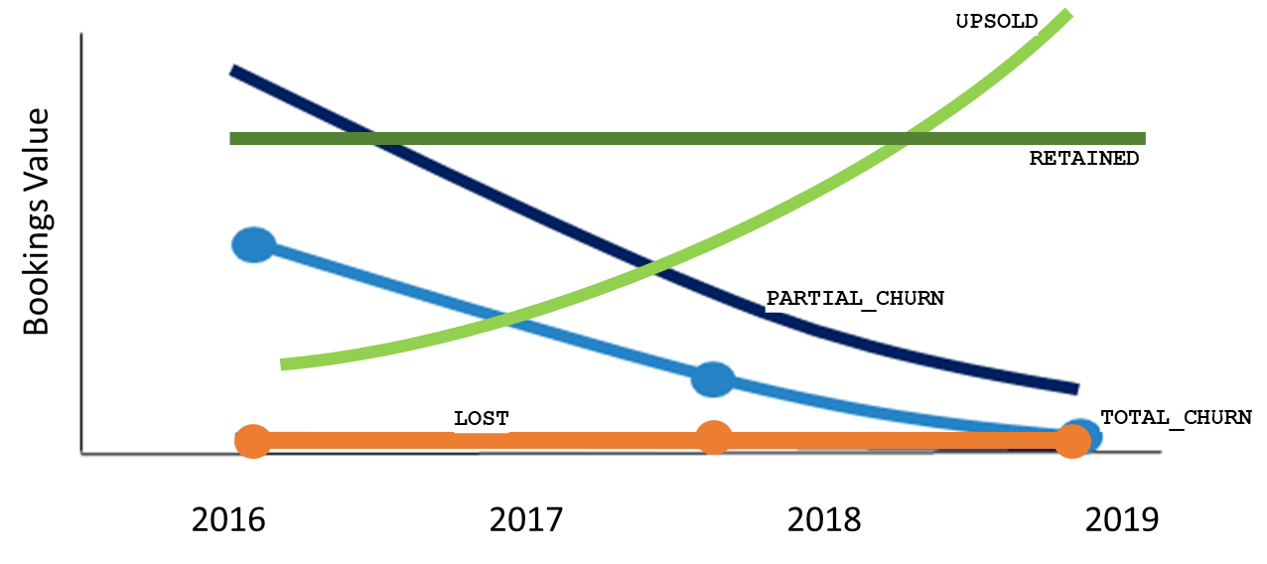

In [42]:
## Ignore contracts with negative values
all_contracts = all_contracts[all_contracts['Bookings - Final Net Price - Agent Discount Amount(Rep)'] >= 0]

### Cancellation contracts have a positive bookings value, but this value is lost once contract is cancelled. So to get correct picture of Total Bookings per Customer * Product, We reverse the sign of the Bookings value on cancellations

In [43]:
# Reverse value of cancelled contracts to get true bookings value
all_contracts.loc[
    all_contracts['CANCELLED'] == 'YES', 
    'Bookings - Final Net Price - Agent Discount Amount(Rep)'] = -all_contracts.loc[
    all_contracts['CANCELLED'] == 'YES', 
    'Bookings - Final Net Price - Agent Discount Amount(Rep)']

In [44]:
print(sum(all_contracts['Bookings - Final Net Price - Agent Discount Amount(Rep)']))

11748059743.528015


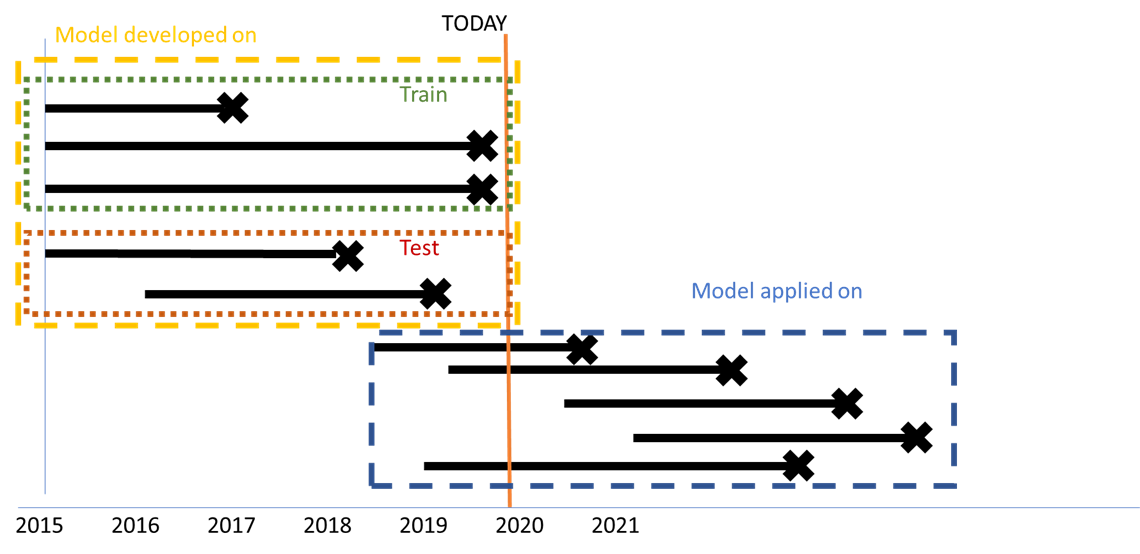

In [45]:
TODAY = datetime.now(tz=None)
active_contracts = (all_contracts['Subscription Start Date'] < TODAY) & (all_contracts['Subscription End Date'] > TODAY)
ended_contracts = (all_contracts['Subscription Start Date'] < TODAY) & (all_contracts['Subscription End Date'] < TODAY)
future_contracts = (all_contracts['Subscription Start Date'] > TODAY)

all_contracts.loc[active_contracts, 'CONTRACT_STATUS'] = 'ACTIVE'
all_contracts.loc[ended_contracts, 'CONTRACT_STATUS'] = 'ENDED'
all_contracts.loc[future_contracts, 'CONTRACT_STATUS'] = 'FUTURE'

all_contracts['CONTRACT_STATUS'].value_counts()

ENDED     2170490
ACTIVE     349988
FUTURE      13374
Name: CONTRACT_STATUS, dtype: int64

In [46]:
print_counts(all_contracts)

Unique Customers : 14604
Unique Products at Level 2 : 30
Unique Customer Product Combinations : 29366
           customers  products
TYPE                          
JOURNALS       10359         5
SOLUTIONS       8792        25


In [47]:
### We will use Ended contracts for Model Training and apply this to ACtive and future contracts

all_contracts_dev = all_contracts[ended_contracts]
all_contracts_target = all_contracts[(active_contracts | future_contracts)]

In [48]:
all_contracts_dev[all_contracts_dev.TYPE == 'JOURNALS']['Product Line Level 2'].value_counts()

Journals Electronic Subscriptions    1778013
Journal Level Sales                   174979
Journals Backfiles                       972
Journals Legacy                           56
Journals Other                             9
Name: Product Line Level 2, dtype: int64

In [49]:
print_counts(all_contracts_dev)

Unique Customers : 14098
Unique Products at Level 2 : 29
Unique Customer Product Combinations : 28129
           customers  products
TYPE                          
JOURNALS       10044         5
SOLUTIONS       8394        24


### Missing IDs actually present in Dev data set

In [50]:
len(np.intersect1d(missing['ECR Id'].unique(), all_contracts_dev["SIS Id  (Agreement SIS)"].unique()))

1515

In [51]:
print_counts(all_contracts_target)

Unique Customers : 8589
Unique Products at Level 2 : 28
Unique Customer Product Combinations : 17372
           customers  products
TYPE                          
JOURNALS        5826         4
SOLUTIONS       5561        24


### Missing IDs actually present in target data set

In [52]:
len(np.intersect1d(missing['ECR Id'].unique(), all_contracts_target["SIS Id  (Agreement SIS)"].unique()))

488

In [53]:
all_contracts_dev.to_pickle('../data/hdf/all_contracts_dev.pickle')
all_contracts_target.to_pickle('../data/hdf/all_contracts_target.pickle')

### Calculating Bookings Value by year

In [54]:
bookings_by_year = pd.pivot_table(all_contracts_dev.groupby(
                        ['SIS Id  (Agreement SIS)','Product Line Level 2', 'Subscription Start Year']
                    ).agg(bookings=("Bookings - Final Net Price - Agent Discount Amount(Rep)", 
                                    sum)).sort_values('bookings', ascending=False).reset_index(), 
                   index=['SIS Id  (Agreement SIS)','Product Line Level 2'], 
                   columns=['Subscription Start Year'], 
                   values=['bookings'], 
                   aggfunc=sum, fill_value=0, margins=False)

# writing to excel takes time that i dont have
#append_df_to_excel('../data/analysis/churn_analysis.xlsx', bookings_by_year, sheet_name='prod_by_year', index=True)

bookings_by_year.columns = bookings_by_year.columns.droplevel(0)
bookings_by_year = bookings_by_year.reset_index().rename_axis(None, axis=1)

In [55]:
year_cols = bookings_by_year.columns[bookings_by_year.columns.str.isnumeric().fillna(True)]
year_cols

Index([2015, 2016, 2017, 2018, 2019, 2020], dtype='object')

In [56]:
ignore_years = [2020, 2021]

year_cols = np.setdiff1d(year_cols, ignore_years)
year_cols

def get_status(x, col):
    churn_status = "NONE"
    #if current value is less than or equal to zero and previous value was greater than zero
    #then customer has gone from a positive value to zero or below zero. i.e. total churn
    if (x[col] < 0) | ((x[col] == 0) & (x[col-1] > 0)): 
        churn_status = "TOTAL_CHURN"
    # if current value is greater than zero and the difference between current value and previous value
    # is less than zero then current value is lower then previous hence partial churn
    elif (x[col] >0) & ((x[col] - x[col-1]) < 0):
        churn_status = "PARTIAL_CHURN"
    elif (x[col] >0) & ((x[col] - x[col-1]) > 0):
        churn_status = "UPSOLD"
    elif (x[col] > 0) & (x[col] == x[col-1]):
        churn_status = "RETAINED"
    elif (x[col] <= 0) & (x[col-1] <= 0):
        churn_status = "LOST"
        
    return churn_status

def get_total_churn_value(x, col):
    churn_value = 0
    if (x[col] < 0) | ((x[col] == 0) & (x[col-1] > 0)): 
        churn_value = x[col-1] - x[col]
        
    return churn_value

def get_partial_churn_value(x, col):
    churn_value = 0
    if (x[col] >0) & ((x[col] - x[col-1]) < 0):
        churn_value = x[col-1] - x[col]
        
    return churn_value

def get_partial_churn_percent(x, col):
    churn_pct = 0
    if (x[col] >0) & ((x[col] - x[col-1]) < 0):
        churn_value = x[col-1] - x[col]
        churn_pct = round((churn_value / (x[col-1])*100))
        
    return churn_pct


# for every year
for col in year_cols[1:]:
    print(f' {col}  -  {col-1}')   
       
    bookings_by_year['churn_'+str(col)] = bookings_by_year.apply(get_status, col=col, axis=1)
    bookings_by_year['total_'+str(col)] = bookings_by_year.apply(get_total_churn_value, col=col, axis=1)
    bookings_by_year['partial_'+str(col)] = bookings_by_year.apply(get_partial_churn_value, col=col, axis=1)
    bookings_by_year['partial_pct_'+str(col)] = bookings_by_year.apply(get_partial_churn_percent, col=col, axis=1)
    


 2016  -  2015
 2017  -  2016
 2018  -  2017
 2019  -  2018


In [57]:
partial_churn_by_year = bookings_by_year[
    ['SIS Id  (Agreement SIS)', 'Product Line Level 2',
     2015, 2016, 2017, 2018, 2019, 2020,
     'partial_pct_2016', 'partial_pct_2017', 'partial_pct_2018', 'partial_pct_2019',
    'partial_2016', 'partial_2017', 'partial_2018', 'partial_2019'    
    ]    
]

partial_churners = (partial_churn_by_year.partial_pct_2016 + partial_churn_by_year.partial_pct_2017 + partial_churn_by_year.partial_pct_2018 + partial_churn_by_year.partial_pct_2019) > 0 

partial_churners = partial_churn_by_year[partial_churners]

In [58]:
partial_churn_pct_cols = ['partial_pct_2016', 'partial_pct_2017', 'partial_pct_2018', 'partial_pct_2019']

for col in partial_churn_pct_cols:
    new_col = col+'_cat'

    partial_churners[new_col] = pd.cut(partial_churners[col],
           bins=[1,5,10,20,30,40,50,60,70,80,
                     max(partial_churners[col])],labels=['1_to_5_pct_churn', '5_to_10_pct_churn', 
                                          '10_to_20_pct_churn', '20_to_30_pct_churn',  '30_to_40_pct_churn', '40_to_50_pct_churn', 
                                          '50_to_60_pct_churn','60_to_70_pct_churn', '70_to_80_pct_churn', 'over_80_pct_churn'])
    


<ipython-input-58-5c2fd244691c>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  partial_churners[new_col] = pd.cut(partial_churners[col],


In [59]:
partial_churners

,SIS Id (Agreement SIS),Product Line Level 2,2015,2016,2017,2018,2019,2020,partial_pct_2016,partial_pct_2017,partial_pct_2018,partial_pct_2019,partial_2016,partial_2017,partial_2018,partial_2019,partial_pct_2016_cat,partial_pct_2017_cat,partial_pct_2018_cat,partial_pct_2019_cat
7,ECR-1,EV,"$40,000","$177,903","$127,603","$-127,603",$0,$0,0,28,0,0,$0,"$50,300",$0,$0,NaN,20_to_30_pct_churn,NaN,NaN
9,ECR-1,Journals Backfiles,"$68,193","$70,239","$68,132","$69,399","$69,399",$0,0,3,0,0,$0,"$2,107",$0,$0,NaN,1_to_5_pct_churn,NaN,NaN
10,ECR-1,Journals Electronic Subscriptions,"$904,372","$931,503","$903,588","$920,395","$920,395",$0,0,3,0,0,$0,"$27,915",$0,$0,NaN,1_to_5_pct_churn,NaN,NaN
12,ECR-1,Reaxys,"$112,000","$112,000","$112,000","$56,000",$0,$0,0,0,50,0,$0,$0,"$56,000",$0,NaN,NaN,40_to_50_pct_churn,NaN
13,ECR-1,SCOPUS,"$179,028","$184,399","$178,867","$188,705","$194,366",$0,0,3,0,0,$0,"$5,532",$0,$0,NaN,1_to_5_pct_churn,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28110,ECR-996,Journal Level Sales,"$40,375","$57,897","$52,661","$52,194","$54,152",$0,0,9,1,0,$0,"$5,236",$466,$0,NaN,5_to_10_pct_churn,NaN,NaN
28113,ECR-996,Mendeley Institutional Edition,"$39,614","$41,595","$58,233","$44,985",$0,$0,0,0,23,0,$0,$0,"$13,248",$0,NaN,NaN,20_to_30_pct_churn,NaN
28116,ECR-996,eBooks,"$39,208","$34,926","$36,235","$37,594","$39,004",$0,11,0,0,0,"$4,283",$0,$0,$0,10_to_20_pct_churn,NaN,NaN,NaN
28118,ECR-997,EV,"$108,771","$113,138","$117,683","$122,287","$27,777",$0,0,0,0,77,$0,$0,$0,"$94,510",NaN,NaN,NaN,70_to_80_pct_churn


In [60]:
pd.set_option('display.float_format', lambda x: '%.2f' % x)
print("=========== 2019 ===========")
print(100. * partial_churners['partial_pct_2019_cat'].value_counts(dropna=True) / partial_churners['partial_pct_2019_cat'].value_counts().sum())
print("=========== 2018 ===========")
print(100. * partial_churners['partial_pct_2018_cat'].value_counts(dropna=True) / partial_churners['partial_pct_2018_cat'].value_counts().sum())
print("=========== 2017 ===========")
print(100. * partial_churners['partial_pct_2017_cat'].value_counts(dropna=True) / partial_churners['partial_pct_2017_cat'].value_counts().sum())
print("=========== 2016 ===========")
print(100. * partial_churners['partial_pct_2016_cat'].value_counts(dropna=True) / partial_churners['partial_pct_2016_cat'].value_counts().sum())

=========== 2019 ===========
40_to_50_pct_churn   25.67
20_to_30_pct_churn   11.83
10_to_20_pct_churn   11.16
5_to_10_pct_churn     9.49
1_to_5_pct_churn      9.49
over_80_pct_churn     8.29
30_to_40_pct_churn    8.22
50_to_60_pct_churn    5.82
60_to_70_pct_churn    5.75
70_to_80_pct_churn    4.28
Name: partial_pct_2019_cat, dtype: float64
=========== 2018 ===========
40_to_50_pct_churn   28.14
10_to_20_pct_churn   11.48
over_80_pct_churn    10.15
1_to_5_pct_churn     10.05
5_to_10_pct_churn     9.23
20_to_30_pct_churn    7.84
30_to_40_pct_churn    7.23
50_to_60_pct_churn    6.46
60_to_70_pct_churn    5.33
70_to_80_pct_churn    4.10
Name: partial_pct_2018_cat, dtype: float64
=========== 2017 ===========
40_to_50_pct_churn   26.33
10_to_20_pct_churn   11.29
50_to_60_pct_churn   10.03
20_to_30_pct_churn    9.77
5_to_10_pct_churn     8.51
1_to_5_pct_churn      8.51
30_to_40_pct_churn    8.20
over_80_pct_churn     7.75
60_to_70_pct_churn    5.87
70_to_80_pct_churn    3.75
Name: partial_pct

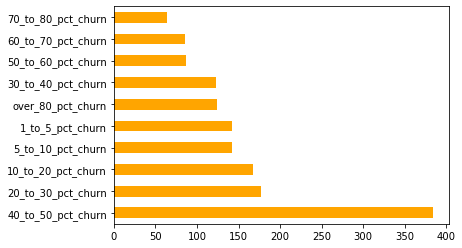

In [61]:
partial_churners['partial_pct_2019_cat'].value_counts(dropna=True).plot(kind='barh', color='orange')

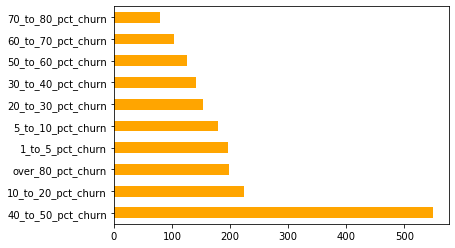

In [62]:
partial_churners['partial_pct_2018_cat'].value_counts(dropna=True).plot(kind='barh', color='orange')

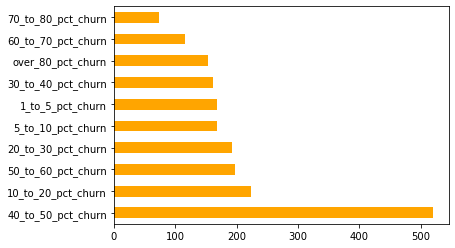

In [63]:
partial_churners['partial_pct_2017_cat'].value_counts(dropna=True).plot(kind='barh', color='orange')

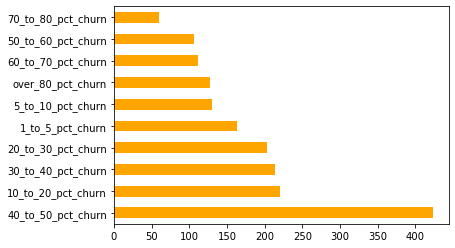

In [64]:
partial_churners['partial_pct_2016_cat'].value_counts(dropna=True).plot(kind='barh', color='orange')

In [65]:
bookings_by_year['TREND_TEXT'] = bookings_by_year['churn_2016'] +'-'+ bookings_by_year['churn_2017'] +'-'+ bookings_by_year['churn_2018']

In [66]:
bookings_by_year[['total_2016', 'partial_2016', 'total_2017', 'partial_2017', 
                  'total_2018', 'partial_2018', 'total_2019', 'partial_2019', ]].sum()

total_2016     120301045.45
partial_2016   242518141.70
total_2017     169732495.40
partial_2017   163888893.23
total_2018     219739244.69
partial_2018   210166751.99
total_2019     364427086.79
partial_2019   269264961.64
dtype: float64

In [56]:
bookings_by_year

,SIS Id (Agreement SIS),Product Line Level 2,2015,2016,2017,2018,2019,2020,churn_2016,total_2016,...,partial_pct_2017,churn_2018,total_2018,partial_2018,partial_pct_2018,churn_2019,total_2019,partial_2019,partial_pct_2019,TREND_TEXT
0,1107461,Knovel,-2245.61,0.00,0.00,0.00,0.00,0,LOST,0.00,...,0,LOST,0.00,0.00,0,LOST,0.00,0.00,0,LOST-LOST-LOST
1,1110518,embase,0.00,0.00,17529.00,0.00,0.00,0,LOST,0.00,...,0,TOTAL_CHURN,17529.00,0.00,0,LOST,0.00,0.00,0,LOST-UPSOLD-TOTAL_CHURN
2,1211459,SSRN,202.10,0.00,0.00,0.00,0.00,0,TOTAL_CHURN,202.10,...,0,LOST,0.00,0.00,0,LOST,0.00,0.00,0,TOTAL_CHURN-LOST-LOST
3,394770,SCOPUS,-4056.77,0.00,0.00,0.00,0.00,0,LOST,0.00,...,0,LOST,0.00,0.00,0,LOST,0.00,0.00,0,LOST-LOST-LOST
4,416754,Journals Electronic Subscriptions,38207.91,0.00,0.00,0.00,0.00,0,TOTAL_CHURN,38207.91,...,0,LOST,0.00,0.00,0,LOST,0.00,0.00,0,TOTAL_CHURN-LOST-LOST
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27997,ECR-998,Journals Electronic Subscriptions,1020821.58,1053712.45,1095160.28,1137674.93,1179126.81,0,UPSOLD,0.00,...,0,UPSOLD,0.00,0.00,0,UPSOLD,0.00,0.00,0,UPSOLD-UPSOLD-UPSOLD
27998,ECR-998,Knovel,30574.00,31950.00,33388.00,34724.00,0.00,0,UPSOLD,0.00,...,0,UPSOLD,0.00,0.00,0,TOTAL_CHURN,34724.00,0.00,0,UPSOLD-UPSOLD-UPSOLD
27999,ECR-998,Reaxys,30778.00,32009.00,33289.00,34621.00,36005.00,0,UPSOLD,0.00,...,0,UPSOLD,0.00,0.00,0,UPSOLD,0.00,0.00,0,UPSOLD-UPSOLD-UPSOLD
28000,ECR-998,SSRN,10933.00,11670.00,890.00,916.70,0.00,0,UPSOLD,0.00,...,92,UPSOLD,0.00,0.00,0,TOTAL_CHURN,916.70,0.00,0,UPSOLD-PARTIAL_CHURN-UPSOLD


In [57]:
x = bookings_by_year.groupby(['TREND_TEXT']).agg(
    total_churn_2016 = ('total_2016' , sum),
    total_churn_2017 = ('total_2017' , sum),
    total_churn_2018 = ('total_2018' , sum),
    total_churn_2019 = ('total_2019' , sum)).reset_index()

y = pd.DataFrame(bookings_by_year.TREND_TEXT.value_counts(dropna=False)).reset_index()

y.columns = ['TREND_TEXT', 'COUNTS']

z = pd.merge(x,y,on='TREND_TEXT').sort_values(by='COUNTS', ascending=False)

z

,TREND_TEXT,total_churn_2016,total_churn_2017,total_churn_2018,total_churn_2019,COUNTS
64,UPSOLD-UPSOLD-UPSOLD,0.00,0.00,0.00,165009194.90,7652
0,LOST-LOST-LOST,0.00,0.00,0.00,244342.53,3349
2,LOST-LOST-UPSOLD,0.00,0.00,0.00,55773074.99,2015
40,TOTAL_CHURN-LOST-LOST,73486087.26,0.00,0.00,227489.21,1853
58,UPSOLD-TOTAL_CHURN-LOST,0.00,85618507.07,0.00,293682.49,1700
...,...,...,...,...,...,...
47,TOTAL_CHURN-UPSOLD-RETAINED,98901.95,0.00,0.00,89890.15,5
4,LOST-TOTAL_CHURN-TOTAL_CHURN,0.00,7598.04,35288.88,0.00,5
25,RETAINED-PARTIAL_CHURN-PARTIAL_CHURN,0.00,0.00,0.00,48713.50,3
44,TOTAL_CHURN-TOTAL_CHURN-TOTAL_CHURN,3978.02,2662.06,143.76,0.00,3


In [58]:
x = bookings_by_year.groupby(['TREND_TEXT']).agg(
    partial_churn_2016 = ('partial_2016' , sum),
    total_churn_2017 = ('partial_2017' , sum),
    total_churn_2018 = ('partial_2018' , sum),
    total_churn_2019 = ('partial_2019' , sum)).reset_index()

y = pd.DataFrame(bookings_by_year.TREND_TEXT.value_counts(dropna=False)).reset_index()

y.columns = ['TREND_TEXT', 'COUNTS']

z = pd.merge(x,y,on='TREND_TEXT').sort_values(by='COUNTS', ascending=False)


z

,TREND_TEXT,partial_churn_2016,total_churn_2017,total_churn_2018,total_churn_2019,COUNTS
64,UPSOLD-UPSOLD-UPSOLD,0.00,0.00,0.00,95401357.36,7652
0,LOST-LOST-LOST,0.00,0.00,0.00,0.00,3349
2,LOST-LOST-UPSOLD,0.00,0.00,0.00,5683243.04,2015
40,TOTAL_CHURN-LOST-LOST,0.00,0.00,0.00,0.00,1853
58,UPSOLD-TOTAL_CHURN-LOST,0.00,0.00,0.00,0.00,1700
...,...,...,...,...,...,...
47,TOTAL_CHURN-UPSOLD-RETAINED,0.00,0.00,0.00,0.00,5
4,LOST-TOTAL_CHURN-TOTAL_CHURN,0.00,0.00,0.00,0.00,5
25,RETAINED-PARTIAL_CHURN-PARTIAL_CHURN,0.00,33440.00,9242.50,0.00,3
44,TOTAL_CHURN-TOTAL_CHURN-TOTAL_CHURN,0.00,0.00,0.00,0.00,3


In [59]:
x = bookings_by_year.groupby(['TREND_TEXT']).agg(
    bookings_2015 = (2015 , sum),
    bookings_2016 = (2016 , sum),
    bookings_2017 = (2017 , sum),
    bookings_2018 = (2018 , sum)).reset_index()

y = pd.DataFrame(bookings_by_year.TREND_TEXT.value_counts(dropna=False)).reset_index()

y.columns = ['TREND_TEXT', 'COUNTS']

pd.merge(x,y,on='TREND_TEXT').sort_values(by='COUNTS', ascending=False)


,TREND_TEXT,bookings_2015,bookings_2016,bookings_2017,bookings_2018,COUNTS
64,UPSOLD-UPSOLD-UPSOLD,731567989.37,826378075.91,893808219.73,1034713397.00,7652
0,LOST-LOST-LOST,-20972619.77,0.00,0.00,0.00,3349
2,LOST-LOST-UPSOLD,-854452.96,0.00,0.00,86492481.41,2015
40,TOTAL_CHURN-LOST-LOST,50756900.36,-22729186.91,0.00,0.00,1853
58,UPSOLD-TOTAL_CHURN-LOST,32283279.85,55048444.07,-30570063.00,0.00,1700
...,...,...,...,...,...,...
47,TOTAL_CHURN-UPSOLD-RETAINED,73303.90,-25598.05,71266.56,71266.56,5
4,LOST-TOTAL_CHURN-TOTAL_CHURN,0.00,0.00,-7598.04,-42886.92,5
25,RETAINED-PARTIAL_CHURN-PARTIAL_CHURN,131926.00,131926.00,98486.00,89243.50,3
44,TOTAL_CHURN-TOTAL_CHURN-TOTAL_CHURN,3978.02,0.00,-2662.06,-2805.82,3


In [60]:
del x,y

In [61]:
pd.set_option('display.float_format', lambda x: '%.2f' % x)
print(100. * bookings_by_year['TREND_TEXT'].value_counts(dropna=False) / len(bookings_by_year['TREND_TEXT']))

UPSOLD-UPSOLD-UPSOLD                   27.33
LOST-LOST-LOST                         11.96
LOST-LOST-UPSOLD                        7.20
TOTAL_CHURN-LOST-LOST                   6.62
UPSOLD-TOTAL_CHURN-LOST                 6.07
                                        ... 
LOST-TOTAL_CHURN-TOTAL_CHURN            0.02
TOTAL_CHURN-UPSOLD-RETAINED             0.02
TOTAL_CHURN-TOTAL_CHURN-TOTAL_CHURN     0.01
RETAINED-PARTIAL_CHURN-PARTIAL_CHURN    0.01
RETAINED-PARTIAL_CHURN-RETAINED         0.01
Name: TREND_TEXT, Length: 65, dtype: float64


In [62]:
bookings_by_year.columns

Index(['SIS Id  (Agreement SIS)',    'Product Line Level 2',
                            2015,                      2016,
                            2017,                      2018,
                            2019,                      2020,
                    'churn_2016',              'total_2016',
                  'partial_2016',        'partial_pct_2016',
                    'churn_2017',              'total_2017',
                  'partial_2017',        'partial_pct_2017',
                    'churn_2018',              'total_2018',
                  'partial_2018',        'partial_pct_2018',
                    'churn_2019',              'total_2019',
                  'partial_2019',        'partial_pct_2019',
                    'TREND_TEXT'],
      dtype='object')

## Customer Revenue Trend over period 2015 to 2019

In [63]:
def get_trend_feature(df, new_colname, groupcols, timecols, prefix=''):
    SECOND_PERIOD = 1
    
    tempdf = df[groupcols + timecols]
    
    tempdf = tempdf.groupby(groupcols).sum()
    
    # increasing trend customers - - all customers with value True
    increasing_cust = (tempdf.diff(axis=1) > 0)[timecols[SECOND_PERIOD:]].apply(all, axis=1)
    increasing_cust_index = increasing_cust[increasing_cust].index
    
    print("INCREASING TREND")
    print(increasing_cust.value_counts())
    # decreasing trend customers - all customers with value False
    decreasing_cust = (tempdf.diff(axis=1) > 0)[timecols[SECOND_PERIOD:]].apply(any, axis=1)
    decreasing_cust_index = decreasing_cust[~decreasing_cust].index
    
    print("DECREASING TREND")
    print(decreasing_cust.value_counts())
    
    #df[new_colname] = 'updown_trend'
    df.loc[:,new_colname] = prefix+'updown_trend'
    df = df.set_index(groupcols)
    
    df.loc[increasing_cust_index, new_colname] = prefix+'increasing_trend'

    df.loc[decreasing_cust_index, new_colname] = prefix+'decreasing_trend'
    
    df = df.reset_index()
    
    return df



<b> Get Customer Bookings Trend over year </b>

In [64]:
bookings_by_year = get_trend_feature(bookings_by_year, 'cust_booking_trend', 
                      groupcols = ['SIS Id  (Agreement SIS)'], 
                      timecols = [2015, 2016,2017,2018,2019],
                      prefix='cust_booking_'
                     )

INCREASING TREND
False    12567
True      1486
dtype: int64
DECREASING TREND
True     12918
False     1135
dtype: int64


<b> Get Customer x Product Bookings Trend over year </b>

In [65]:
bookings_by_year = get_trend_feature(bookings_by_year, 'cust_prod_booking_trend', 
                      groupcols = ['SIS Id  (Agreement SIS)', 'Product Line Level 2'], 
                      timecols = [2015, 2016,2017,2018,2019],
                      prefix='cust_prod_booking_'
                     )

INCREASING TREND
False    23996
True      4006
dtype: int64
DECREASING TREND
True     25410
False     2592
dtype: int64


In [66]:
bookings_by_year['cust_booking_trend'].value_counts()

cust_booking_updown_trend        23557
cust_booking_increasing_trend     3092
cust_booking_decreasing_trend     1353
Name: cust_booking_trend, dtype: int64

In [67]:
bookings_by_year['cust_prod_booking_trend'].value_counts()

cust_prod_booking_updown_trend        21404
cust_prod_booking_increasing_trend     4006
cust_prod_booking_decreasing_trend     2592
Name: cust_prod_booking_trend, dtype: int64

### Yearly churn of customers with decreasing trend

In [68]:
year_cols = ['churn_2016','churn_2017','churn_2018','churn_2019']

In [69]:
def get_trend_churn_matrix(df, trendcol, timecols, churn_chron_name='churn_year', churn_colname='CHURN'):
    
    df = df[[trendcol] + timecols]
    
    df = pd.melt(df, id_vars=[trendcol], value_vars=timecols,  
                 var_name=churn_chron_name, value_name=churn_colname).reset_index()
    
    df = df.groupby([trendcol] + [churn_colname, churn_chron_name]).count().reset_index()
    df = df.rename(columns={'index': 'counts'})
    
    df = df.groupby([trendcol] + [churn_colname, churn_chron_name])['counts'].sum().unstack(churn_chron_name)
    
    return df

# One row per Customer x Products combinations

so counts represent unique customer x product combinations

In [70]:
cust_trend_matrix = get_trend_churn_matrix(bookings_by_year, trendcol='cust_booking_trend', timecols=year_cols)

#append_df_to_excel('../data/analysis/churn_analysis.xlsx', cust_trend_matrix, sheet_name='cust_booking_trend', index=True)

cust_trend_matrix

churn_year                                   churn_2016  churn_2017  churn_2018  churn_2019
cust_booking_trend            CHURN                                                        
cust_booking_decreasing_trend LOST                  696        1174        1270        1249
                              PARTIAL_CHURN          76          35          21          12
                              RETAINED               55          15          12           5
                              TOTAL_CHURN           484         103          28          77
                              UPSOLD                 42          26          22          10
cust_booking_increasing_trend LOST                  444         384         315         277
                              PARTIAL_CHURN         102         116         116          81
                              RETAINED               41          37          19          25
                              TOTAL_CHURN            50          48          70         214
                              UPSOLD               2455        2507        2572        2495
cust_booking_updown_trend     LOST                 7124        6116        5963        7469
                              PARTIAL_CHURN        1738        1948        1935        1503
                              RETAINED              462         336         404         380
                              TOTAL_CHURN          2118        2954        3228        7221
                              UPSOLD              12115       12203       12027        6984

In [71]:
prod_trend_matrix = get_trend_churn_matrix(bookings_by_year, trendcol='cust_prod_booking_trend', timecols=year_cols)

#append_df_to_excel('../data/analysis/churn_analysis.xlsx', prod_trend_matrix, sheet_name='cust_prod_booking_trend', index=True)

prod_trend_matrix

churn_year                                        churn_2016  churn_2017  churn_2018  churn_2019
cust_prod_booking_trend            CHURN                                                        
cust_prod_booking_decreasing_trend LOST              1448.00     2293.00     2486.00     2448.00
                                   PARTIAL_CHURN      147.00       54.00       36.00       17.00
                                   RETAINED           152.00       49.00       41.00       13.00
                                   TOTAL_CHURN        845.00      196.00       29.00      114.00
cust_prod_booking_increasing_trend LOST                 3.00         nan         nan         nan
                                   UPSOLD            4003.00     4006.00     4006.00     4006.00
cust_prod_booking_updown_trend     LOST              6813.00     5381.00     5062.00     6547.00
                                   PARTIAL_CHURN     1769.00     2045.00     2036.00     1579.00
                                   RETAINED           406.00      339.00      394.00      397.00
                                   TOTAL_CHURN       1807.00     2909.00     3297.00     7398.00
                                   UPSOLD           10609.00    10730.00    10615.00     5483.00

In [72]:
print(bookings_by_year.shape)
print(len(bookings_by_year['SIS Id  (Agreement SIS)'].unique()))
print(len(bookings_by_year['Product Line Level 2'].unique()))
print(len(bookings_by_year.drop_duplicates(['SIS Id  (Agreement SIS)','Product Line Level 2'])))

(28002, 27)
14053
29
28002


In [73]:
pd.set_option('display.float_format', lambda x: '%.2f' % x)
print("=========== 2019 ===========")
print(100. * bookings_by_year['churn_2019'].value_counts(dropna=False) / len(bookings_by_year['churn_2019']))
print("=========== 2018 ===========")
print(100. * bookings_by_year['churn_2018'].value_counts(dropna=False) / len(bookings_by_year['churn_2018']))
print("=========== 2017 ===========")
print(100. * bookings_by_year['churn_2017'].value_counts(dropna=False) / len(bookings_by_year['churn_2017']))
print("=========== 2016 ===========")
print(100. * bookings_by_year['churn_2016'].value_counts(dropna=False) / len(bookings_by_year['churn_2016']))


=========== 2019 ===========
UPSOLD          33.89
LOST            32.12
TOTAL_CHURN     26.83
PARTIAL_CHURN    5.70
RETAINED         1.46
Name: churn_2019, dtype: float64
=========== 2018 ===========
UPSOLD          52.21
LOST            26.96
TOTAL_CHURN     11.88
PARTIAL_CHURN    7.40
RETAINED         1.55
Name: churn_2018, dtype: float64
=========== 2017 ===========
UPSOLD          52.62
LOST            27.41
TOTAL_CHURN     11.09
PARTIAL_CHURN    7.50
RETAINED         1.39
Name: churn_2017, dtype: float64
=========== 2016 ===========
UPSOLD          52.18
LOST            29.51
TOTAL_CHURN      9.47
PARTIAL_CHURN    6.84
RETAINED         1.99
Name: churn_2016, dtype: float64


In [74]:
bookings_by_year

,SIS Id (Agreement SIS),Product Line Level 2,2015,2016,2017,2018,2019,2020,churn_2016,total_2016,...,total_2018,partial_2018,partial_pct_2018,churn_2019,total_2019,partial_2019,partial_pct_2019,TREND_TEXT,cust_booking_trend,cust_prod_booking_trend
0,1107461,Knovel,-2245.61,0.00,0.00,0.00,0.00,0,LOST,0.00,...,0.00,0.00,0,LOST,0.00,0.00,0,LOST-LOST-LOST,cust_booking_updown_trend,cust_prod_booking_updown_trend
1,1110518,embase,0.00,0.00,17529.00,0.00,0.00,0,LOST,0.00,...,17529.00,0.00,0,LOST,0.00,0.00,0,LOST-UPSOLD-TOTAL_CHURN,cust_booking_updown_trend,cust_prod_booking_updown_trend
2,1211459,SSRN,202.10,0.00,0.00,0.00,0.00,0,TOTAL_CHURN,202.10,...,0.00,0.00,0,LOST,0.00,0.00,0,TOTAL_CHURN-LOST-LOST,cust_booking_decreasing_trend,cust_prod_booking_decreasing_trend
3,394770,SCOPUS,-4056.77,0.00,0.00,0.00,0.00,0,LOST,0.00,...,0.00,0.00,0,LOST,0.00,0.00,0,LOST-LOST-LOST,cust_booking_updown_trend,cust_prod_booking_updown_trend
4,416754,Journals Electronic Subscriptions,38207.91,0.00,0.00,0.00,0.00,0,TOTAL_CHURN,38207.91,...,0.00,0.00,0,LOST,0.00,0.00,0,TOTAL_CHURN-LOST-LOST,cust_booking_decreasing_trend,cust_prod_booking_decreasing_trend
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27997,ECR-998,Journals Electronic Subscriptions,1020821.58,1053712.45,1095160.28,1137674.93,1179126.81,0,UPSOLD,0.00,...,0.00,0.00,0,UPSOLD,0.00,0.00,0,UPSOLD-UPSOLD-UPSOLD,cust_booking_updown_trend,cust_prod_booking_increasing_trend
27998,ECR-998,Knovel,30574.00,31950.00,33388.00,34724.00,0.00,0,UPSOLD,0.00,...,0.00,0.00,0,TOTAL_CHURN,34724.00,0.00,0,UPSOLD-UPSOLD-UPSOLD,cust_booking_updown_trend,cust_prod_booking_updown_trend
27999,ECR-998,Reaxys,30778.00,32009.00,33289.00,34621.00,36005.00,0,UPSOLD,0.00,...,0.00,0.00,0,UPSOLD,0.00,0.00,0,UPSOLD-UPSOLD-UPSOLD,cust_booking_updown_trend,cust_prod_booking_increasing_trend
28000,ECR-998,SSRN,10933.00,11670.00,890.00,916.70,0.00,0,UPSOLD,0.00,...,0.00,0.00,0,TOTAL_CHURN,916.70,0.00,0,UPSOLD-PARTIAL_CHURN-UPSOLD,cust_booking_updown_trend,cust_prod_booking_updown_trend


### Churn Year

The Churn seen in 2019 seems to be higher because for model dev we have considered ended contracts and ignored active contracts. there are many contracts in 2019 that havent yet ended as of TODAY and as a result they dont feature in our model dev dataset.

Thus churn year 2018 is the label we will use to train our model

In [75]:
bookings_by_year[bookings_by_year.cust_prod_booking_trend == 'cust_prod_booking_increasing_trend'].head()

,SIS Id (Agreement SIS),Product Line Level 2,2015,2016,2017,2018,2019,2020,churn_2016,total_2016,...,total_2018,partial_2018,partial_pct_2018,churn_2019,total_2019,partial_2019,partial_pct_2019,TREND_TEXT,cust_booking_trend,cust_prod_booking_trend
11,ECR-1,Knovel,133000.00,136990.00,141100.00,156304.00,160993.00,0,UPSOLD,0.00,...,0.00,0.00,0,UPSOLD,0.00,0.00,0,UPSOLD-UPSOLD-UPSOLD,cust_booking_updown_trend,cust_prod_booking_increasing_trend
31,ECR-10000700,Journals Electronic Subscriptions,256032.00,273177.65,292074.90,306909.00,322519.00,0,UPSOLD,0.00,...,0.00,0.00,0,UPSOLD,0.00,0.00,0,UPSOLD-UPSOLD-UPSOLD,cust_booking_increasing_trend,cust_prod_booking_increasing_trend
33,ECR-10000700,Reaxys,27628.00,29009.00,30169.00,31677.00,32940.00,0,UPSOLD,0.00,...,0.00,0.00,0,UPSOLD,0.00,0.00,0,UPSOLD-UPSOLD-UPSOLD,cust_booking_increasing_trend,cust_prod_booking_increasing_trend
34,ECR-10000700,SCOPUS,36582.00,38045.00,39567.00,41150.00,43002.00,0,UPSOLD,0.00,...,0.00,0.00,0,UPSOLD,0.00,0.00,0,UPSOLD-UPSOLD-UPSOLD,cust_booking_increasing_trend,cust_prod_booking_increasing_trend
93,ECR-1004,EV,169004.00,174074.00,179296.00,184675.00,345003.00,0,UPSOLD,0.00,...,0.00,0.00,0,UPSOLD,0.00,0.00,0,UPSOLD-UPSOLD-UPSOLD,cust_booking_updown_trend,cust_prod_booking_increasing_trend


In [76]:
bookings_by_year['3_yr_booking_change_pct'] = bookings_by_year.apply(lambda x: pct_change(x, 2015, 2018), axis=1)

In [77]:
bookings_by_year.sort_values(by='3_yr_booking_change_pct', ascending=False)

,SIS Id (Agreement SIS),Product Line Level 2,2015,2016,2017,2018,2019,2020,churn_2016,total_2016,...,partial_2018,partial_pct_2018,churn_2019,total_2019,partial_2019,partial_pct_2019,TREND_TEXT,cust_booking_trend,cust_prod_booking_trend,3_yr_booking_change_pct
12467,ECR-380603,Journals Electronic Subscriptions,0.00,13870953.53,22167341.17,14467869.91,14467869.92,0,UPSOLD,0.00,...,7699471.27,35,UPSOLD,0.00,0.00,0,UPSOLD-UPSOLD-PARTIAL_CHURN,cust_booking_updown_trend,cust_prod_booking_updown_trend,14467869.91
1856,ECR-1128518,Journals Electronic Subscriptions,0.00,5718336.14,6070094.00,6443100.00,13337387.70,0,UPSOLD,0.00,...,0.00,0,UPSOLD,0.00,0.00,0,UPSOLD-UPSOLD-UPSOLD,cust_booking_increasing_trend,cust_prod_booking_increasing_trend,6443100.00
20099,ECR-52792,Journals Electronic Subscriptions,0.00,0.00,0.00,5074877.93,2642047.59,0,LOST,0.00,...,0.00,0,PARTIAL_CHURN,0.00,2432830.34,48,LOST-LOST-UPSOLD,cust_booking_updown_trend,cust_prod_booking_updown_trend,5074877.93
21102,ECR-553270,Journals Electronic Subscriptions,0.00,8357496.91,5764699.64,2969800.41,0.00,0,UPSOLD,0.00,...,2794899.23,48,TOTAL_CHURN,2969800.41,0.00,0,UPSOLD-PARTIAL_CHURN-PARTIAL_CHURN,cust_booking_updown_trend,cust_prod_booking_updown_trend,2969800.41
8858,ECR-28712,Journals Electronic Subscriptions,0.00,0.00,0.00,2760119.62,2723827.68,0,LOST,0.00,...,0.00,0,PARTIAL_CHURN,0.00,36291.94,1,LOST-LOST-UPSOLD,cust_booking_updown_trend,cust_prod_booking_updown_trend,2760119.62
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13766,ECR-402406,Journals Electronic Subscriptions,0.00,90000.00,227000.00,-227000.00,531360.10,0,UPSOLD,0.00,...,0.00,0,UPSOLD,0.00,0.00,0,UPSOLD-UPSOLD-TOTAL_CHURN,cust_booking_updown_trend,cust_prod_booking_updown_trend,-227000.00
19751,ECR-521241,Pharmapendium,0.00,0.00,201742.70,-237259.85,0.00,0,LOST,0.00,...,0.00,0,LOST,0.00,0.00,0,LOST-UPSOLD-TOTAL_CHURN,cust_booking_updown_trend,cust_prod_booking_updown_trend,-237259.85
17858,ECR-459818,Knovel,0.00,318368.07,318369.03,-318369.03,0.00,0,UPSOLD,0.00,...,0.00,0,LOST,0.00,0.00,0,UPSOLD-UPSOLD-TOTAL_CHURN,cust_booking_updown_trend,cust_prod_booking_updown_trend,-318369.03
2005,ECR-1142834,Journals Electronic Subscriptions,0.00,524072.70,1286942.90,-368333.35,0.00,0,UPSOLD,0.00,...,0.00,0,LOST,0.00,0.00,0,UPSOLD-UPSOLD-TOTAL_CHURN,cust_booking_updown_trend,cust_prod_booking_updown_trend,-368333.35


In [78]:
print(max(bookings_by_year['3_yr_booking_change_pct']))
print(min(bookings_by_year['3_yr_booking_change_pct']))

14467869.90698054
-444303.3372


In [79]:
bookings_by_year['3_yr_booking_change'] = pd.cut(bookings_by_year['3_yr_booking_change_pct'],
       bins=[min(bookings_by_year['3_yr_booking_change_pct']),-100,-75,-50,-25,0,25,50,75,100,
                 max(bookings_by_year['3_yr_booking_change_pct'])],labels=['over_100_pc_dec', '75_to_100_pc_dec', 
                                      '50_to_75_pc_dec', '25_to_50_pc_dec',  '0_to_25_pc_dec', '0_to_25_pc_inc', 
                                      '25_to_50_pc_inc','50_to_75_pc_inc', '75_to_100_pc_inc', 'over_100_pc_inc'])

In [80]:
bookings_by_year['3_yr_booking_change'] = bookings_by_year['3_yr_booking_change'].astype(str)
bookings_by_year['3_yr_booking_change'].value_counts()

0_to_25_pc_dec      10284
0_to_25_pc_inc       6530
over_100_pc_inc      6324
over_100_pc_dec      1545
25_to_50_pc_inc      1346
25_to_50_pc_dec       671
50_to_75_pc_inc       429
50_to_75_pc_dec       315
75_to_100_pc_dec      297
75_to_100_pc_inc      260
nan                     1
Name: 3_yr_booking_change, dtype: int64

In [81]:
print(100. * bookings_by_year['3_yr_booking_change'].value_counts(dropna=False) / len(bookings_by_year['3_yr_booking_change']))

0_to_25_pc_dec     36.73
0_to_25_pc_inc     23.32
over_100_pc_inc    22.58
over_100_pc_dec     5.52
25_to_50_pc_inc     4.81
25_to_50_pc_dec     2.40
50_to_75_pc_inc     1.53
50_to_75_pc_dec     1.12
75_to_100_pc_dec    1.06
75_to_100_pc_inc    0.93
nan                 0.00
Name: 3_yr_booking_change, dtype: float64


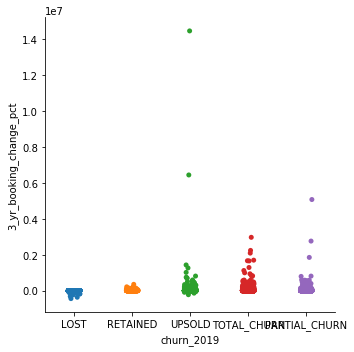

In [82]:
import seaborn as sns
sns.catplot(x="churn_2019", y="3_yr_booking_change_pct", data=bookings_by_year)

In [83]:
bookings_by_year.dtypes

SIS Id  (Agreement SIS)     object
Product Line Level 2        object
2015                       float64
2016                       float64
2017                       float64
2018                       float64
2019                       float64
2020                         int64
churn_2016                  object
total_2016                 float64
partial_2016               float64
partial_pct_2016             int64
churn_2017                  object
total_2017                 float64
partial_2017               float64
partial_pct_2017             int64
churn_2018                  object
total_2018                 float64
partial_2018               float64
partial_pct_2018             int64
churn_2019                  object
total_2019                 float64
partial_2019               float64
partial_pct_2019             int64
TREND_TEXT                  object
cust_booking_trend          object
cust_prod_booking_trend     object
3_yr_booking_change_pct    float64
3_yr_booking_change 

In [84]:
bookings_by_year.head()

,SIS Id (Agreement SIS),Product Line Level 2,2015,2016,2017,2018,2019,2020,churn_2016,total_2016,...,partial_pct_2018,churn_2019,total_2019,partial_2019,partial_pct_2019,TREND_TEXT,cust_booking_trend,cust_prod_booking_trend,3_yr_booking_change_pct,3_yr_booking_change
0,1107461,Knovel,-2245.61,0.00,0.00,0.00,0.00,0,LOST,0.00,...,0,LOST,0.00,0.00,0,LOST-LOST-LOST,cust_booking_updown_trend,cust_prod_booking_updown_trend,0.00,0_to_25_pc_dec
1,1110518,embase,0.00,0.00,17529.00,0.00,0.00,0,LOST,0.00,...,0,LOST,0.00,0.00,0,LOST-UPSOLD-TOTAL_CHURN,cust_booking_updown_trend,cust_prod_booking_updown_trend,0.00,0_to_25_pc_dec
2,1211459,SSRN,202.10,0.00,0.00,0.00,0.00,0,TOTAL_CHURN,202.10,...,0,LOST,0.00,0.00,0,TOTAL_CHURN-LOST-LOST,cust_booking_decreasing_trend,cust_prod_booking_decreasing_trend,0.00,0_to_25_pc_dec
3,394770,SCOPUS,-4056.77,0.00,0.00,0.00,0.00,0,LOST,0.00,...,0,LOST,0.00,0.00,0,LOST-LOST-LOST,cust_booking_updown_trend,cust_prod_booking_updown_trend,0.00,0_to_25_pc_dec
4,416754,Journals Electronic Subscriptions,38207.91,0.00,0.00,0.00,0.00,0,TOTAL_CHURN,38207.91,...,0,LOST,0.00,0.00,0,TOTAL_CHURN-LOST-LOST,cust_booking_decreasing_trend,cust_prod_booking_decreasing_trend,0.00,0_to_25_pc_dec


In [85]:
# Having some issue saving churn_label to HDF to saving to pickle 

In [86]:
bookings_by_year.to_pickle('../data/hdf/churn_label_dev.pickle')

In [87]:
#bookings_by_year.to_hdf(path_to_hdf_datastore, key="churn_label")

### SD USAGE DATA

In [88]:
usage_per_jnl_act = pd.read_csv('../data/02. Data collection/01. Customer Data/05. Product Usage/SD_USAGE/PA-4968 usage per jnl per acct.csv')

In [89]:
usage_per_jnl_act.columns

Index(['account_name', 'account_number', 'ecr', 'sis', 'entitlement', 'year',
       'issn', 'journal_title', 'fta'],
      dtype='object')

In [90]:
usage_per_jnl_act.head()

,account_name,account_number,ecr,sis,entitlement,year,issn,journal_title,fta
0,Gyeongsang National University,C000019138,ECR-136936,136936,subject_collection,2018-01-01 00:00:00.000000,0981-9428,Plant Physiology and Biochemistry,1019
1,University of Málaga,C000032799,ECR-2195,2195,freedom_collection,2018-01-01 00:00:00.000000,1053-8119,NeuroImage,692
2,Walailak University,C000054431,NaN,404797,freedom_collection,2018-01-01 00:00:00.000000,0981-9428,Plant Physiology and Biochemistry,140
3,BS - The Copenhagen Business School Library CBS,C000033618,NaN,246661,freedom_collection,2018-01-01 00:00:00.000000,0748-7983,European Journal of Surgical Oncology,36
4,Indian Institute of Technology Jodhpur,C000117573,ECR-735166,735166,gold_open_access,2018-01-01 00:00:00.000000,1053-8119,NeuroImage,28


In [94]:
usage_per_jnl_act['year'] = pd.to_datetime(usage_per_jnl_act['year'] ).dt.strftime('%Y-%m-%d')
usage_per_jnl_act['year'] = pd.to_datetime(usage_per_jnl_act['year'] , format='%Y-%m-%d')
usage_per_jnl_act['year'] = usage_per_jnl_act['year'].map(lambda x: x.year )
usage_per_jnl_act['year'].dtypes

MemoryError: 

In [94]:
usage_per_jnl_act['year'].value_counts(dropna=False)

2018    17198075
2017    15726833
2016    14404087
2015    12655300
2014    11327652
2013    10250374
Name: year, dtype: int64

In [95]:
usage_per_jnl_act['entitlement'].value_counts()

freedom_collection    25401101
gold_open_access      21077336
subscribed            14948717
subject_collection     5276366
backfile               5250567
free                   3916439
open_archive           2420679
purchased              1975776
unsubscribed           1268955
condition                26385
Name: entitlement, dtype: int64

<b> Read JLS List from excel </b>

In [96]:
JLS_list = pd.read_csv('../data/02. Data collection/01. Customer Data/10. Other/JLS titles.csv')

In [97]:
JLS_list.head()

,PRODUCT_ID,DESCRIPTION,Journal Type,?Product,Product Description,Vendor Part Number (ISSN),Product Line Level 3,Product Line Level 4
0,02215,Cell Chemical Biology,Cell Press,02215,Cell Chemical Biology,2451-9456,Cell Press,nan
1,02216,Current Biology,Cell Press,02216,Current Biology,0960-9822,Cell Press,nan
2,02218,Structure,Cell Press,02218,Structure,0969-2126,Cell Press,nan
3,07590,Cell,Cell Press,07590,Cell,0092-8674,Cell Press,nan
4,07591,Immunity,Cell Press,07591,Immunity,1074-7613,Cell Press,nan


In [98]:
JLS_list = JLS_list[['Vendor Part Number (ISSN)']]
JLS_list['Product Line Level 2'] = 'Journal Level Sales'

In [99]:
usage_per_jnl_act = pd.merge(usage_per_jnl_act, JLS_list, left_on='issn', right_on='Vendor Part Number (ISSN)', how='left')

In [100]:
usage_per_jnl_act['Product Line Level 2'].value_counts(dropna=False)

NaN                    78985097
Journal Level Sales     2577224
Name: Product Line Level 2, dtype: int64

 <b> As suggested by SD Usage data owner what is not in JLS list is JES </b>


In [101]:
usage_per_jnl_act.fillna({'Product Line Level 2': 'Journals Electronic Subscriptions'}, inplace=True)

In [102]:
usage_per_jnl_act['Product Line Level 2'].value_counts(dropna=False)

Journals Electronic Subscriptions    78985097
Journal Level Sales                   2577224
Name: Product Line Level 2, dtype: int64

In [103]:
usage_per_jnl_act.head()

,account_name,account_number,ecr,sis,entitlement,year,issn,journal_title,fta,Vendor Part Number (ISSN),Product Line Level 2
0,Gyeongsang National University,C000019138,ECR-136936,136936,subject_collection,2018,0981-9428,Plant Physiology and Biochemistry,1019,NaN,Journals Electronic Subscriptions
1,University of Málaga,C000032799,ECR-2195,2195,freedom_collection,2018,1053-8119,NeuroImage,692,NaN,Journals Electronic Subscriptions
2,Walailak University,C000054431,NaN,404797,freedom_collection,2018,0981-9428,Plant Physiology and Biochemistry,140,NaN,Journals Electronic Subscriptions
3,BS - The Copenhagen Business School Library CBS,C000033618,NaN,246661,freedom_collection,2018,0748-7983,European Journal of Surgical Oncology,36,NaN,Journals Electronic Subscriptions
4,Indian Institute of Technology Jodhpur,C000117573,ECR-735166,735166,gold_open_access,2018,1053-8119,NeuroImage,28,NaN,Journals Electronic Subscriptions


In [104]:
# Aggregate usage at product level 2

In [105]:
usage_total = usage_per_jnl_act.groupby(['ecr', 'Product Line Level 2', 'year']).agg(usage = ('fta', sum))

In [106]:
usage_total = pd.pivot_table(usage_total, 
                       index=['ecr','Product Line Level 2'], 
                       columns=['year'], 
                       values=['usage'], 
                       aggfunc=sum, fill_value=0, margins=False)

usage_total.reset_index(inplace=True)

usage_total.columns = pd.Index([(e[0] if not e[1] else e[1]) for e in usage_total.columns.tolist()])

In [107]:
usage_total

,ecr,Product Line Level 2,2013,2014,2015,2016,2017,2018
0,ECR-1,Journal Level Sales,751,902,1428,722,1242,941
1,ECR-1,Journals Electronic Subscriptions,99500,100664,106520,56687,85358,59515
2,ECR-1000,Journal Level Sales,2642,3781,4511,5943,6115,8232
3,ECR-1000,Journals Electronic Subscriptions,152884,191022,206858,218457,211762,242622
4,ECR-10000212,Journal Level Sales,0,0,0,0,0,21
...,...,...,...,...,...,...,...,...
35759,ECR-986,Journals Electronic Subscriptions,344637,374811,526989,474289,482704,579983
35760,ECR-992,Journal Level Sales,4721,5029,2824,3865,3425,4724
35761,ECR-992,Journals Electronic Subscriptions,153011,157788,158612,171516,160771,196122
35762,ECR-994,Journal Level Sales,345,260,290,462,501,976


In [108]:
usage_total = get_trend_feature(usage_total, 'jnl_usage_trend', groupcols=['ecr', 'Product Line Level 2'], 
                      timecols=[2013,2014,2015,2016,2017,2018], prefix='')

INCREASING TREND
False    32674
True      3090
dtype: int64
DECREASING TREND
True     34619
False     1145
dtype: int64


In [109]:
pd.set_option('display.float_format', lambda x: '%.0f' % x)
# Weighted average usage over three years with latest year having highest weight
usage_total['3_yr_mean_usage'] = usage_total[2016]*0.2 + usage_total[2017]*0.3 + usage_total[2018]*0.5

usage_total

,ecr,Product Line Level 2,2013,2014,2015,2016,2017,2018,jnl_usage_trend,3_yr_mean_usage
0,ECR-1,Journal Level Sales,751,902,1428,722,1242,941,updown_trend,988
1,ECR-1,Journals Electronic Subscriptions,99500,100664,106520,56687,85358,59515,updown_trend,66702
2,ECR-1000,Journal Level Sales,2642,3781,4511,5943,6115,8232,increasing_trend,7139
3,ECR-1000,Journals Electronic Subscriptions,152884,191022,206858,218457,211762,242622,updown_trend,228531
4,ECR-10000212,Journal Level Sales,0,0,0,0,0,21,updown_trend,10
...,...,...,...,...,...,...,...,...,...,...
35759,ECR-986,Journals Electronic Subscriptions,344637,374811,526989,474289,482704,579983,updown_trend,529660
35760,ECR-992,Journal Level Sales,4721,5029,2824,3865,3425,4724,updown_trend,4162
35761,ECR-992,Journals Electronic Subscriptions,153011,157788,158612,171516,160771,196122,updown_trend,180596
35762,ECR-994,Journal Level Sales,345,260,290,462,501,976,updown_trend,731


In [110]:
usage_total['3_yr_usg_change_pct'] = usage_total.apply(lambda x: pct_change(x, 2016, 2018), axis=1)

In [111]:
usage_total

,ecr,Product Line Level 2,2013,2014,2015,2016,2017,2018,jnl_usage_trend,3_yr_mean_usage,3_yr_usg_change_pct
0,ECR-1,Journal Level Sales,751,902,1428,722,1242,941,updown_trend,988,30
1,ECR-1,Journals Electronic Subscriptions,99500,100664,106520,56687,85358,59515,updown_trend,66702,5
2,ECR-1000,Journal Level Sales,2642,3781,4511,5943,6115,8232,increasing_trend,7139,39
3,ECR-1000,Journals Electronic Subscriptions,152884,191022,206858,218457,211762,242622,updown_trend,228531,11
4,ECR-10000212,Journal Level Sales,0,0,0,0,0,21,updown_trend,10,21
...,...,...,...,...,...,...,...,...,...,...,...
35759,ECR-986,Journals Electronic Subscriptions,344637,374811,526989,474289,482704,579983,updown_trend,529660,22
35760,ECR-992,Journal Level Sales,4721,5029,2824,3865,3425,4724,updown_trend,4162,22
35761,ECR-992,Journals Electronic Subscriptions,153011,157788,158612,171516,160771,196122,updown_trend,180596,14
35762,ECR-994,Journal Level Sales,345,260,290,462,501,976,updown_trend,731,111


In [112]:
### bucket percent change
min(usage_total['3_yr_usg_change_pct'])


-99.99578818163768

In [113]:
max(usage_total['3_yr_usg_change_pct'])

2153566.6666666665

In [114]:
usage_total['3_yr_usg_change'] = pd.cut(usage_total['3_yr_usg_change_pct'],
       bins=[min(usage_total['3_yr_usg_change_pct']),
             -75,-50,-25,0,25,50, 75,
             max(usage_total['3_yr_usg_change_pct'])],
                                        labels=['over_75pc_usg_dec', 'over_50pc_usg_dec', 
                                                                  'over_25pc_usg_dec', 'less_25pc_usg_dec', 
                                                                  'less_25pc_usg_inc', 'over_25pc_usg_inc', 
                                                                  'over_50pc_usg_inc', 'over_75pc_usg_inc'])

In [115]:
usage_total['3_yr_usg_change'].value_counts()

over_75pc_usg_inc    9545
less_25pc_usg_dec    7718
less_25pc_usg_inc    7017
over_25pc_usg_inc    3788
over_50pc_usg_inc    2353
over_25pc_usg_dec    2068
over_50pc_usg_dec    1698
over_75pc_usg_dec    1576
Name: 3_yr_usg_change, dtype: int64

In [123]:
usage_total.head()

,ecr,Product Line Level 2,2013,2014,2015,2016,2017,2018,jnl_usage_trend,3_yr_mean_usage,3_yr_usg_change_pct,3_yr_usg_change
0,ECR-1,Journal Level Sales,751,902,1428,722,1242,941,updown_trend,988,30,over_25pc_usg_inc
1,ECR-1,Journals Electronic Subscriptions,99500,100664,106520,56687,85358,59515,updown_trend,66702,5,less_25pc_usg_inc
2,ECR-1000,Journal Level Sales,2642,3781,4511,5943,6115,8232,increasing_trend,7139,39,over_25pc_usg_inc
3,ECR-1000,Journals Electronic Subscriptions,152884,191022,206858,218457,211762,242622,updown_trend,228531,11,less_25pc_usg_inc
4,ECR-10000212,Journal Level Sales,0,0,0,0,0,21,updown_trend,10,21,less_25pc_usg_inc


In [385]:
# you might experience some issue saving to HDF in that case we save this data set to pickle, but ideal to keep it in HDF store

In [117]:
usage_total.to_pickle('../data/hdf/sd_cust_prod_usage.pickle')

In [120]:
usage_total['3_yr_usg_change'] = usage_total['3_yr_usg_change'].astype(str)

In [121]:
usage_total.dtypes

ecr                      object
Product Line Level 2     object
2013                      int64
2014                      int64
2015                      int64
2016                      int64
2017                      int64
2018                      int64
jnl_usage_trend          object
3_yr_mean_usage         float64
3_yr_usg_change_pct     float64
3_yr_usg_change          object
dtype: object

In [122]:
usage_total.to_hdf(path_to_hdf_datastore, key='sd_cust_prod_usage')

C:\Users\DHURIS\.virtualenvs\rss-customer-churn-B66CRNaT\lib\site-packages\pandas\io\pytables.py:282: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->integer,key->block1_items] [items->None]

  f(store)
